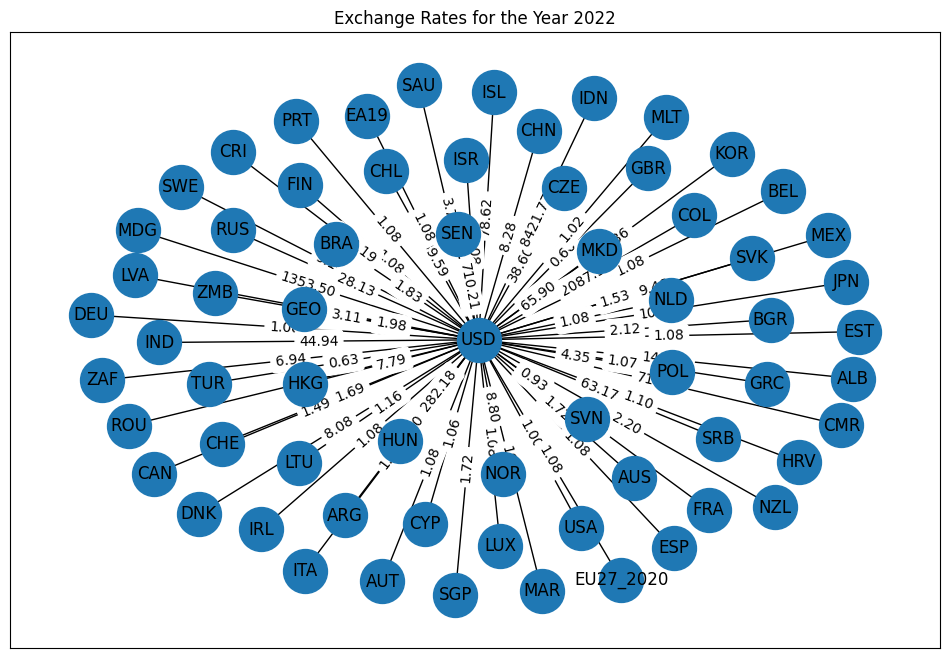

In [96]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
data = pd.read_csv("/content/DP_LIVE_19102023190941932.csv")
# Filter the data for the year 2022
data_2022 = data[data["TIME"] == 2000]

# Create a new graph
G = nx.Graph()

# Add nodes and edges
for index, row in data_2022.iterrows():
    G.add_node(row['LOCATION'], currency=row['LOCATION'])
    G.add_edge(row['LOCATION'], 'USD', rate=row['Value'])

# Plot the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=1000)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['rate']:.2f}" for u, v, d in G.edges(data=True)})
plt.title("Exchange Rates for the Year 2022")
plt.show()


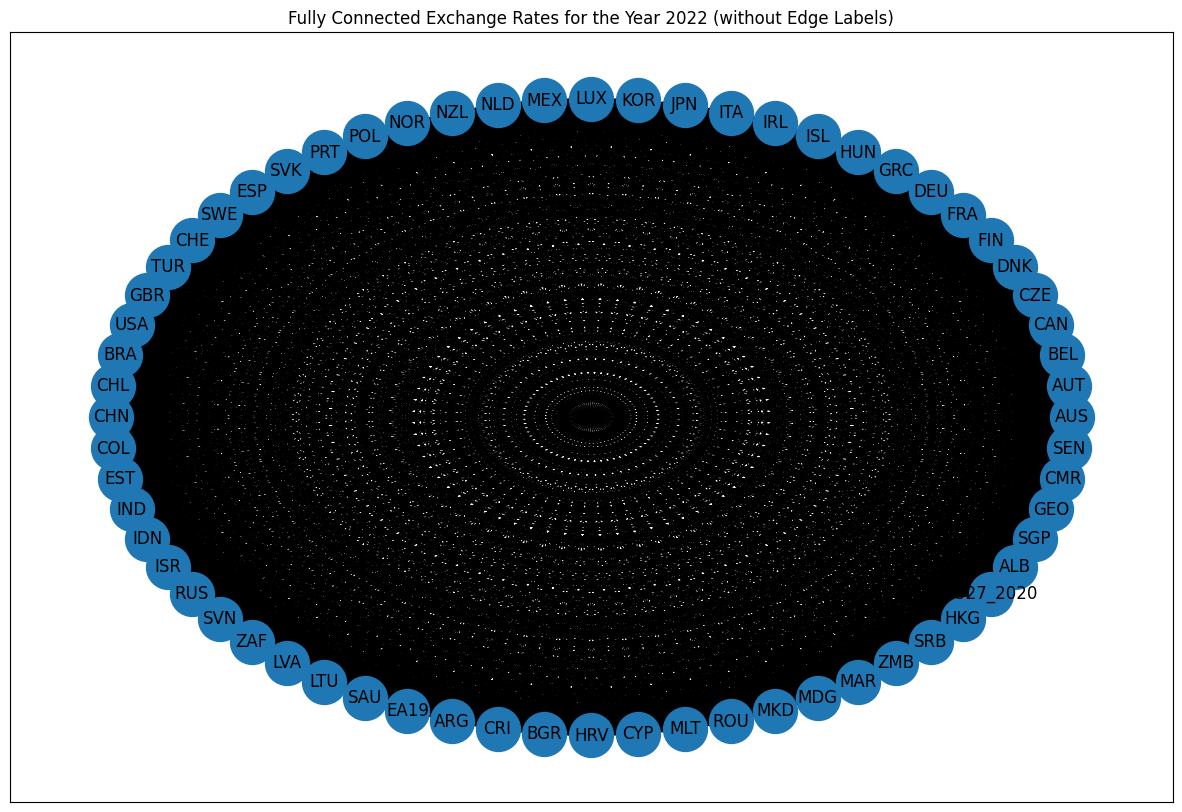

In [97]:
# Recreate the directed graph with the correct computation
G_corrected = nx.DiGraph()


# Add nodes for all currencies
for location in data_2022['LOCATION'].unique():
    G_corrected.add_node(location)

# Compute exchange rates for every pair of currencies and add directed edges
for index1, row1 in data_2022.iterrows():
    for index2, row2 in data_2022.iterrows():
        if row1['LOCATION'] != row2['LOCATION']:
            # Compute the exchange rate using USD as a reference
            rate = (row2['Value'] / row1['Value'])

            G_corrected.add_edge(row1['LOCATION'], row2['LOCATION'], rate=rate)

# Return the number of nodes and edges to confirm the structure.
len(G_corrected.nodes()), len(G_corrected.edges())
plt.figure(figsize=(15, 10))
pos = nx.circular_layout(G_corrected)
nx.draw_networkx_nodes(G_corrected, pos, node_size=1000)
nx.draw_networkx_edges(G_corrected, pos, arrowsize=15, node_size=1000)
nx.draw_networkx_labels(G_corrected, pos)
plt.title("Fully Connected Exchange Rates for the Year 2022 (without Edge Labels)")
plt.show()

In [98]:
# Create a new directed graph
G_reconstructed = nx.DiGraph()

# Add nodes for all currencies
for location in data_2022['LOCATION'].unique():
    G_reconstructed.add_node(location)

# Add edges with rates (from every currency to every other currency)
for source in data_2022['LOCATION'].unique():
    for target in data_2022['LOCATION'].unique():
        if source != target:
            rate = data_2022[data_2022['LOCATION'] == target]['Value'].values[0] / data_2022[data_2022['LOCATION'] == source]['Value'].values[0]
            G_reconstructed.add_edge(source, target, rate=rate)

# Verify the structure of the reconstructed graph
sample_edges_reconstructed = [("AUS", "SGP"), ("CAN", "MDG"), ("JPN", "EU27_2020")]
sample_edges_data_reconstructed = {edge: G_reconstructed[edge[0]][edge[1]] for edge in sample_edges_reconstructed}

sample_edges_data_reconstructed

{('AUS', 'SGP'): {'rate': 0.9994990801976081},
 ('CAN', 'MDG'): {'rate': 911.2034699211118},
 ('JPN', 'EU27_2020'): {'rate': 0.010046861194851065}}

In [99]:
def compute_profit_for_cycle(graph, cycle, starting_amount=1):
    """
    Compute the profit for a given arbitrage cycle.

    Parameters:
    - graph: The currency graph with exchange rates as edge weights.
    - cycle: The cycle representing the arbitrage opportunity.
    - starting_amount: The starting amount to compute the profit.

    Returns:
    - The profit after completing the cycle.
    """
    amount = starting_amount
    for i in range(len(cycle) - 1):
        amount *= graph[cycle[i]][cycle[i + 1]]['rate']
    return amount - starting_amount

In [100]:
def find_arbitrage_opportunity_refined(graph, start_currency, denomination):
    # Log-transform the edge weights
    for u, v, d in graph.edges(data=True):
        d['weight'] = -np.log(d['rate'])

    # Initialize distances and predecessors
    distances = {node: float('inf') for node in graph.nodes()}
    predecessors = {node: None for node in graph.nodes()}
    distances[start_currency] = 0

    # Relax the edges
    for _ in range(len(graph.nodes()) - 1):
        for u, v, d in graph.edges(data=True):
            if distances[u] + d['weight'] < distances[v]:
                distances[v] = distances[u] + d['weight']
                predecessors[v] = u

    # Check for negative-weight cycles
    cycle_nodes = set()
    for u, v, d in graph.edges(data=True):
        if distances[u] + d['weight'] < distances[v]:
            cycle_nodes.add(v)
            temp = u
            while temp not in cycle_nodes:
                cycle_nodes.add(temp)
                temp = predecessors[temp]

    if cycle_nodes:
        # Extract one of the nodes in the cycle and retrieve the whole cycle using the predecessors
        cycle_start = next(iter(cycle_nodes))
        cycle = [cycle_start]
        while predecessors[cycle_start] not in cycle:
            cycle.append(predecessors[cycle_start])
            cycle_start = predecessors[cycle_start]
        cycle.append(predecessors[cycle_start])
        return cycle[::-1]

    return None

# Re-check for arbitrage opportunities for each currency
arbitrage_opportunities_refined = {}
for currency in G_corrected.nodes():
    path = find_arbitrage_opportunity_refined(G_corrected, currency, denomination)
    if path:
        arbitrage_opportunities_refined[currency] = path

# Compute the profit for each arbitrage opportunity
profits_refined = {}
for currency, path in arbitrage_opportunities_refined.items():
    profit = compute_profit_for_cycle(G_corrected, path, denomination)
    profits_refined[currency] = {
        "path": path,
        "profit": profit
    }

profits_refined

{'AUS': {'path': ['SGP', 'ZMB', 'CMR', 'SGP', 'HKG', 'HUN'],
  'profit': 8134.026194297677},
 'AUT': {'path': ['HKG',
   'SRB',
   'CYP',
   'MKD',
   'ZMB',
   'CMR',
   'SGP',
   'HKG',
   'HUN'],
  'profit': 1760.8915326805352},
 'BEL': {'path': ['HKG',
   'SRB',
   'CYP',
   'MKD',
   'ZMB',
   'CMR',
   'SGP',
   'HKG',
   'HUN'],
  'profit': 1760.8915326805352},
 'CAN': {'path': ['SGP', 'ZMB', 'CMR', 'SGP', 'HKG', 'HUN'],
  'profit': 8134.026194297677},
 'CZE': {'path': ['SGP', 'HKG', 'SGP', 'HUN'], 'profit': 8134.026194297675},
 'DNK': {'path': ['EU27_2020',
   'MAR',
   'MKD',
   'MDG',
   'EU27_2020',
   'HKG',
   'SRB',
   'HUN'],
  'profit': 12981.211964477861},
 'FIN': {'path': ['HKG',
   'SRB',
   'CYP',
   'MKD',
   'ZMB',
   'CMR',
   'SGP',
   'HKG',
   'HUN'],
  'profit': 1760.8915326805352},
 'FRA': {'path': ['HKG',
   'SRB',
   'CYP',
   'MKD',
   'ZMB',
   'CMR',
   'SGP',
   'HKG',
   'HUN'],
  'profit': 1760.8915326805352},
 'DEU': {'path': ['HKG',
   'SRB',
   'C

In [101]:
profits_refined


{'AUS': {'path': ['SGP', 'ZMB', 'CMR', 'SGP', 'HKG', 'HUN'],
  'profit': 8134.026194297677},
 'AUT': {'path': ['HKG',
   'SRB',
   'CYP',
   'MKD',
   'ZMB',
   'CMR',
   'SGP',
   'HKG',
   'HUN'],
  'profit': 1760.8915326805352},
 'BEL': {'path': ['HKG',
   'SRB',
   'CYP',
   'MKD',
   'ZMB',
   'CMR',
   'SGP',
   'HKG',
   'HUN'],
  'profit': 1760.8915326805352},
 'CAN': {'path': ['SGP', 'ZMB', 'CMR', 'SGP', 'HKG', 'HUN'],
  'profit': 8134.026194297677},
 'CZE': {'path': ['SGP', 'HKG', 'SGP', 'HUN'], 'profit': 8134.026194297675},
 'DNK': {'path': ['EU27_2020',
   'MAR',
   'MKD',
   'MDG',
   'EU27_2020',
   'HKG',
   'SRB',
   'HUN'],
  'profit': 12981.211964477861},
 'FIN': {'path': ['HKG',
   'SRB',
   'CYP',
   'MKD',
   'ZMB',
   'CMR',
   'SGP',
   'HKG',
   'HUN'],
  'profit': 1760.8915326805352},
 'FRA': {'path': ['HKG',
   'SRB',
   'CYP',
   'MKD',
   'ZMB',
   'CMR',
   'SGP',
   'HKG',
   'HUN'],
  'profit': 1760.8915326805352},
 'DEU': {'path': ['HKG',
   'SRB',
   'C

In [102]:
# Create a new directed graph
G_reconstructed = nx.DiGraph()

# Add nodes for all currencies
for location in data_2022['LOCATION'].unique():
    G_reconstructed.add_node(location)

# Add edges with rates (from every currency to every other currency)
for source in data_2022['LOCATION'].unique():
    for target in data_2022['LOCATION'].unique():
        if source != target:
            rate = data_2022[data_2022['LOCATION'] == target]['Value'].values[0] / data_2022[data_2022['LOCATION'] == source]['Value'].values[0]
            G_reconstructed.add_edge(source, target, rate=-np.log(rate))

# Verify the structure of the reconstructed graph
sample_edges_reconstructed = [("AUS", "SGP"), ("CAN", "MDG"), ("JPN", "EU27_2020")]
sample_edges_data_reconstructed = {edge: G_reconstructed[edge[0]][edge[1]] for edge in sample_edges_reconstructed}

sample_edges_data_reconstructed

{('AUS', 'SGP'): {'rate': 0.000501045304628865},
 ('CAN', 'MDG'): {'rate': -6.814766220204203},
 ('JPN', 'EU27_2020'): {'rate': 4.6004950121790555}}

In [103]:
import math
from collections import defaultdict

def bellman_ford_return_cycle(g, s):
    n = len(g.nodes())
    d = defaultdict(lambda: math.inf)  # distances dict
    p = defaultdict(lambda: -1)  # predecessor dict
    d[s] = 0

    for _ in range(n - 1):
        for u, v in g.edges():
            # Bellman-Ford relaxation
            weight = g[u][v]["weight"]
            print(weight)
            if d[u] + weight < d[v]:
                d[v] = d[u] + weight
                p[v] = u  # update pred

        # Find cycles if they exist
        all_cycles = []
        seen = defaultdict(lambda: False)

        for u, v in g.edges():
            if seen[v]:
                continue
            # If we can relax further there must be a neg-weight cycle
            weight = g[u][v]["weight"]
            if d[u] + weight < d[v]:
                cycle = []
                x = v
                while True:
                    # Walk back along preds until a cycle is found
                    seen[x] = True
                    cycle.append(x)
                    x = p[x]
                    if x == v or x in cycle:
                        break
                # Slice to get the cyclic portion
                idx = cycle.index(x)
                cycle.append(x)
                all_cycles.append(cycle[idx:][::-1])
        return all_cycles

In [104]:
def all_negative_cycles(g):
    all_paths = []
    for v in g.nodes():
        all_paths.append(bellman_ford_return_cycle(g, vw))
    flattened = [item for sublist in all_paths for item in sublist]
    return [list(i) for i in set(tuple(j) for j in flattened)]

In [105]:
def calculate_arb(cycle, g, verbose=True):
    total = 0
    for (p1, p2) in zip(cycle, cycle[1:]):
        total += g[p1][p2]["weight"]
    arb = np.exp(-total) - 1
    if verbose:
        print("Path:", cycle)
        print(f"{arb*100:.2g}%\n")
    return arb


def find_arbitrage(G):

    g = G

    if nx.negative_edge_cycle(g):
        print("ARBITRAGE FOUND\n" + "=" * 15 + "\n")
        for p in all_negative_cycles(g):
            calculate_arb(p, g)
    else:
        print("No arbitrage opportunities")

In [106]:
nx.negative_edge_cycle(G_corrected)

True

In [107]:
G_reconstructed